In [1]:
%config InlineBackend.figure_format = 'retina'

%config IPCompleter.use_jedi = False
import multiprocessing.popen_spawn_posix

import os
import numpy as np
import pandas as pd
import dask
import dask.dataframe as dd

from daskdecorators import dask_hist

from hist import Hist
import mplhep as hep

from functools import reduce
import treecorr

import matplotlib
import matplotlib.pyplot as plt

In [2]:
matplotlib.rcParams['savefig.dpi'] = 120
matplotlib.rcParams['figure.dpi'] = 120

In [3]:
from dask.distributed import Client, LocalCluster

cluster = LocalCluster(n_workers=6, 
                       threads_per_worker=1,
                       memory_limit='5Gb')
client = Client(cluster)

#dask.config.config["distributed"]["dashboard"]["link"] = "{JUPYTERHUB_SERVICE_PREFIX}proxy/{host}:{port}/status"
#client = Client(scheduler_file='/global/cscratch1/sd/cwalter/dask-mpi/scheduler.json')

client

Client Scheduler: tcp://127.0.0.1:62729 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 6 Cores: 6 Memory: 30.00 GB


In [4]:
from scipy.special import comb

#scratch= os.environ["SCRATCH"]
scratch = '/Users/walter/LSST/work'

selected = ['id', 'mag_r', 'z', 'ra', 'dec', 'g1', 'g2']

#df = dd.read_parquet(f'{scratch}/parquet-skysim/*.parquet', columns=selected, engine='pyarrow')
df = dd.read_parquet(f'{scratch}/skysim-sampled', columns=selected, engine='pyarrow')
df = df.persist()

number_in_df = df.index.size.compute()
print('Columns:', df.columns.values, '#Rows:', number_in_df/1e9)
print(f'There are {number_in_df:,d} elements in the area with {comb(number_in_df, 2, exact=True):,d} total combinations')

Columns: ['id' 'mag_r' 'z' 'ra' 'dec' 'g1' 'g2'] #Rows: 0.0626302
There are 62,630,200 elements in the area with 1,961,270,944,704,900 total combinations


ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x1835548b0>, cbar=<matplotlib.colorbar.Colorbar object at 0x1835546d0>)

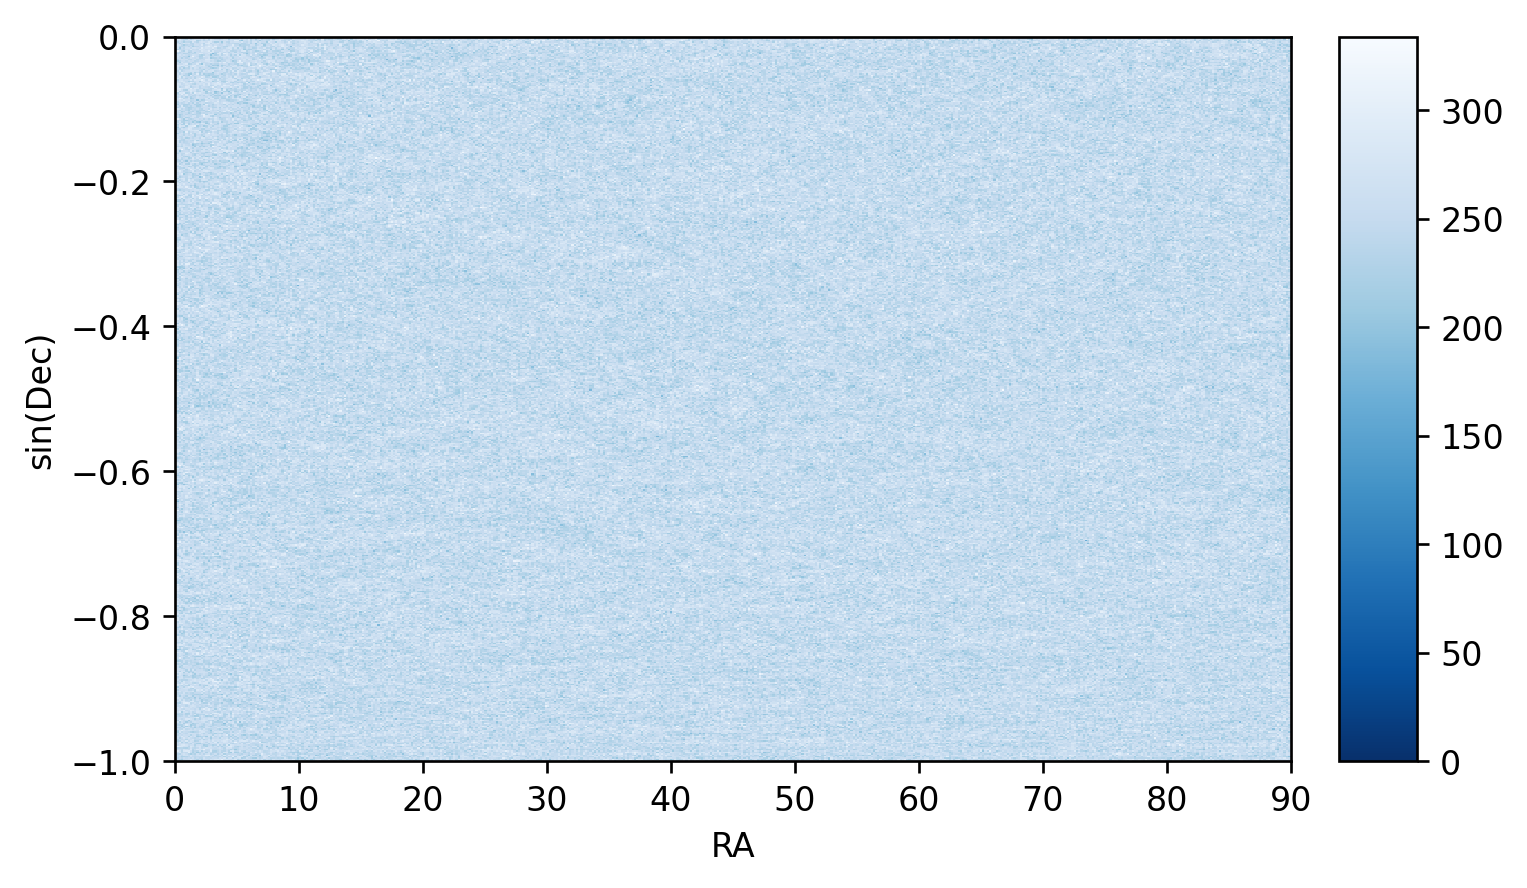

In [5]:
from scipy.special import sindg as sindg
    
@dask_hist
def dask_survey(df):

    h = Hist.new.Reg(500, 0, 90, name='RA').Reg(500, sindg(-90), sindg(0), name='Dec', label='sin(Dec)').Double()
    h.fill(df.ra, sindg(df.dec))
    return h

heatmap = dask_survey(df)
heatmap.plot2d(cmap='Blues_r', vmin=0)

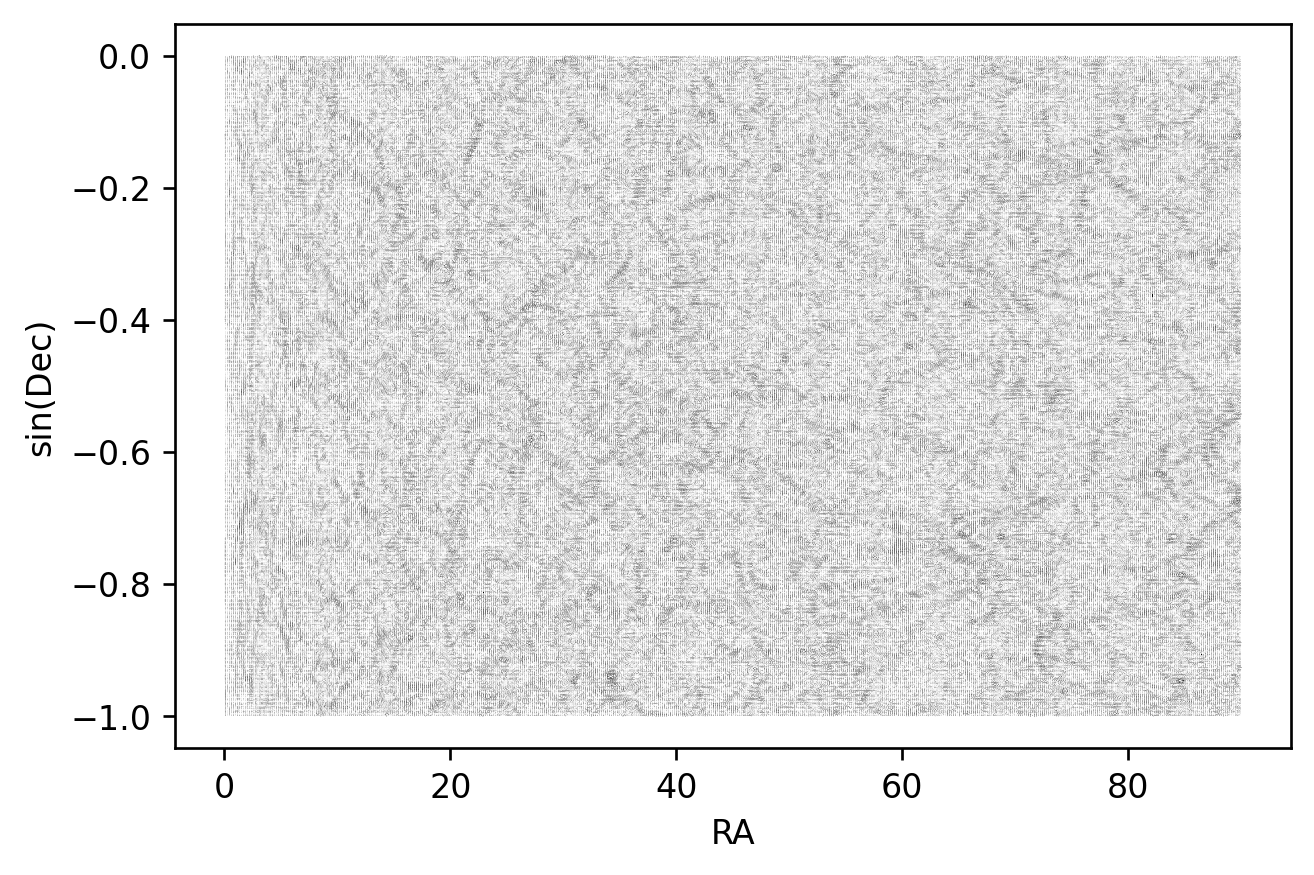

In [6]:
binning = 500

@dask_hist
def mean_g1_equal(df):
    
    h = Hist.new.Reg(binning, 0, 90, name='RA').Reg(binning, sindg(-90), sindg(0), name='Dec').Mean()
    h.fill(df.ra, sindg(df.dec), sample=df.g1)
    return h

@dask_hist
def mean_g2_equal(df):
    
    h = Hist.new.Reg(binning, 0, 90, name='RA').Reg(binning, sindg(-90), sindg(0), name='Dec').Mean()
    h.fill(df.ra, sindg(df.dec), sample=df.g2)
    return h

g1_hist = mean_g1_equal(df)
g2_hist = mean_g2_equal(df)

x_centers = g1_hist.axes[0].centers
y_centers = g1_hist.axes[1].centers

g1 = g1_hist.view().value
g2 = -g2_hist.view().value

reduced_shear = g1 + g2*1j
magnitude = np.abs(reduced_shear)
phi = np.angle(reduced_shear)/2

plt.quiver(x_centers, y_centers, magnitude*np.cos(phi), magnitude*np.sin(phi), pivot='mid', 
           headaxislength=0, headlength=0, headwidth=0, width=.0003)
plt.xlabel('RA')
plt.ylabel('sin(Dec)');

In [7]:
def treecorr_chunk(dataframe):
    
    cat = treecorr.Catalog(ra=dataframe.ra, dec=dataframe.dec, g1=dataframe.g1, g2=dataframe.g2, flip_g2=True, ra_units='deg', dec_units='deg')

    gg = treecorr.GGCorrelation(min_sep=1., max_sep=200., nbins=20, num_threads=1, sep_units='arcmin')
    gg.process_auto(cat)
    return gg, cat.varg*cat.sumw, cat.sumw

result = df.map_partitions(treecorr_chunk)

In [8]:
computed = result.compute()
result_gg, result_varg, result_sum = list(zip(*computed))

gg = reduce(treecorr.GGCorrelation.__iadd__, result_gg)
varg = sum(result_varg)/sum(result_sum)

gg.finalize(varg, varg)

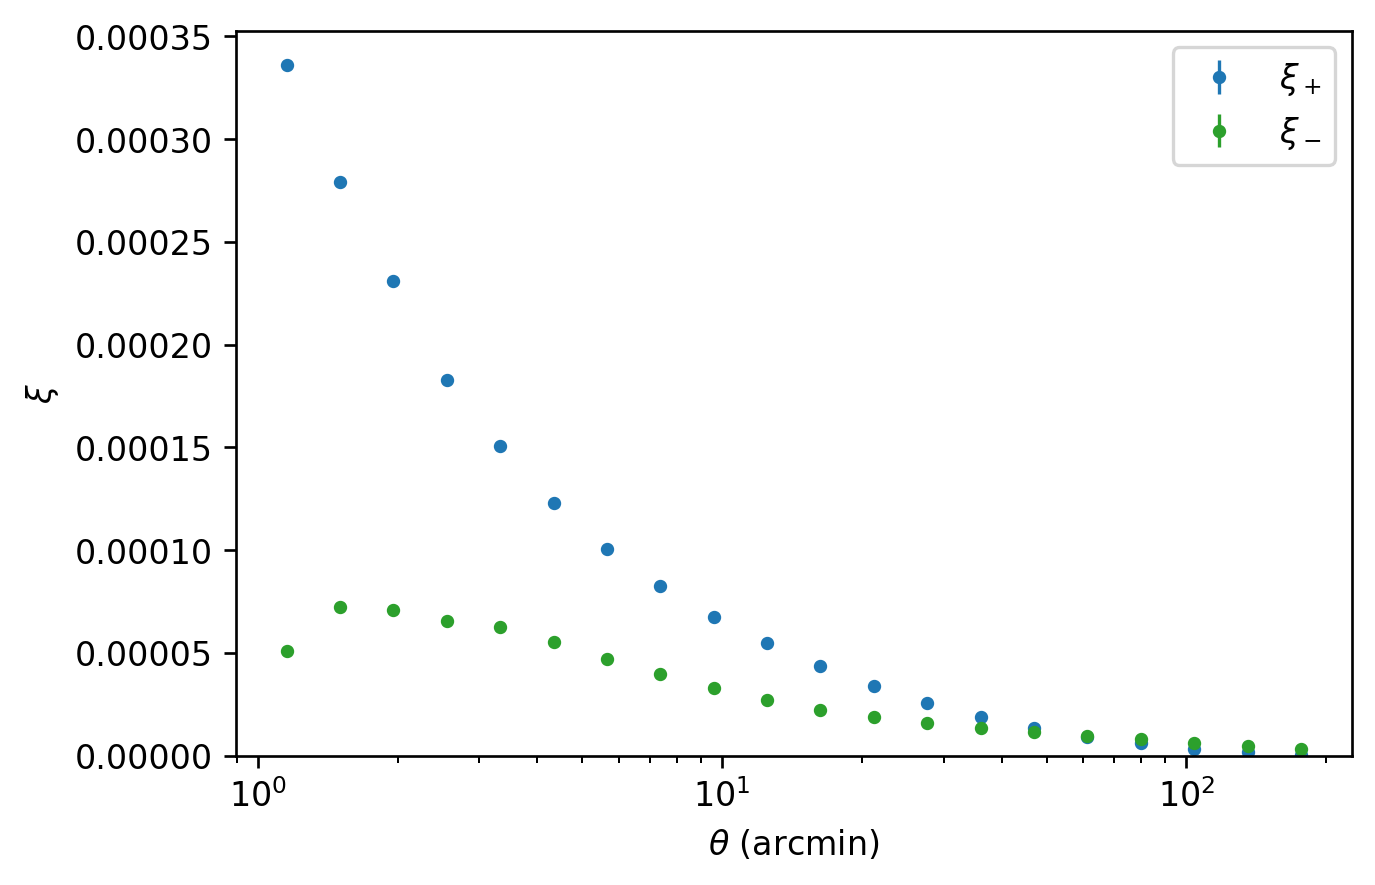

In [9]:
bins = np.append(gg.left_edges, gg.right_edges[-1])
xip, xim = gg.xip, gg.xim
sigma_p, sigma_m = np.sqrt(gg.varxip), np.sqrt(gg.varxip)

hep.histplot(xip, bins=bins, yerr=sigma_p, histtype='errorbar', markersize=6, label=r'$\xi_+$')
hep.histplot(xim, bins=bins, yerr=sigma_m, histtype='errorbar', markersize=6, label=r'$\xi_-$')
plt.xscale('log')
#plt.yscale('log')
#plt.ylim(bottom=0.5e-6)
plt.legend()
plt.ylabel(r'$\xi$')
plt.xlabel(r'$\theta$ (arcmin)');